In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-13 17:14:28.529337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 17:14:28.529394: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df = pd.read_csv('../data.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

Text(0.5, 0, 'Date')

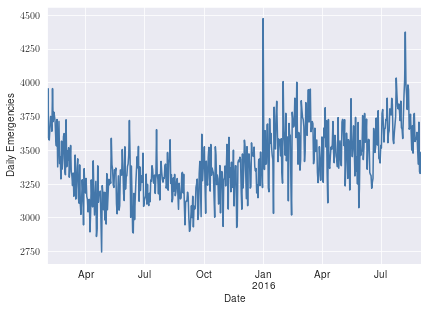

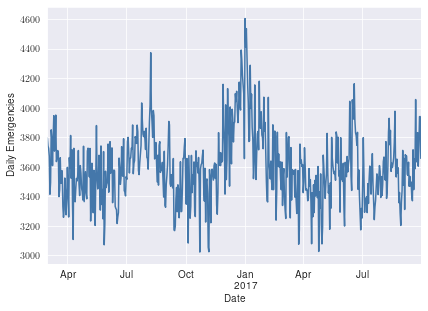

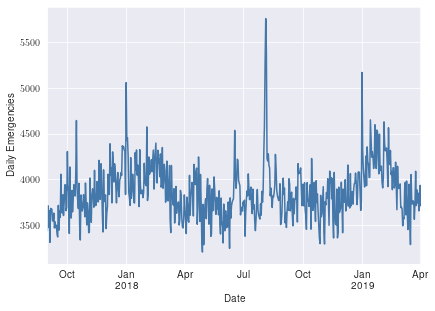

In [7]:
df1.plot(figsize=(17*cm,12*cm), legend=None, color=colors[0])
plt.ylabel('Daily Emergencies')
plt.xlabel('Date')
df2.plot(figsize=(17*cm,12*cm), legend=None, color=colors[0])
plt.ylabel('Daily Emergencies')
plt.xlabel('Date')
df3.plot(figsize=(17*cm,12*cm), legend=None, color=colors[0])
plt.ylabel('Daily Emergencies')
plt.xlabel('Date')

### Create batches of training data (12 months)

In [8]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [9]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(250, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(250, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=400, verbose=1, callbacks=[callback])
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [10]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
    
    x_input = train[-n_steps_in:]
    x_input = x_input.reshape((1, n_steps_in))
    pred = model.predict(x_input)
    
    actual = actual.tolist()
    for i in range(0, len(actual)): 
        actual[i] = actual[i][0]
    actual = array(actual)
        
    mae, rmse, smape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred[0], n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(actual[i:i+n_steps_in], pred[0], mae, rmse, smape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in))
        pred = model.predict(x_input)
    
    return mae, rmse, smape

In [11]:
def sMAPE(Y_actual,Y_Predicted):
    smape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return smape

In [12]:
def measure_error(actual, pred, step, index):
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

2022-10-13 17:14:33.998477: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 17:14:33.998528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 17:14:33.999045: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/400
16/16 [==============================] - 1s 6ms/step - loss: 3320209.0000
Epoch 2/400
16/16 [==============================] - 0s 5ms/step - loss: 238203.6250
Epoch 3/400
16/16 [==============================] - 0s 5ms/step - loss: 66450.1562
Epoch 4/400
16/16 [==============================] - 0s 5ms/step - loss: 40825.2422
Epoch 5/400
16/16 [==============================] - 0s 5ms/step - loss: 36964.1523
Epoch 6/400
16/16 [==============================] - 0s 6ms/step - loss: 36189.7656
Epoch 7/400
16/16 [==============================] - 0s 5ms/step - loss: 36397.6367
Epoch 8/400
16/16 [==============================] - 0s 5ms/step - loss: 37041.8555
Epoch 9/400
16/16 [==============================] - 0s 5ms/step - loss: 35765.6211
Epoch 10/400
16/16 [==============================] - 0s 6ms/step - loss: 34878.2227
Epoch 11/400
16/16 [==============================] - 0s 5ms/step - loss: 35624.7344
Epoch 12/400
16/16 [==============================] - 0s 5ms/step - los

16/16 [==============================] - 0s 8ms/step - loss: 30467.6738
Epoch 98/400
16/16 [==============================] - 0s 8ms/step - loss: 31121.6270
Epoch 99/400
16/16 [==============================] - 0s 6ms/step - loss: 30893.1074
Epoch 100/400
16/16 [==============================] - 0s 7ms/step - loss: 33869.2070
Epoch 101/400
16/16 [==============================] - 0s 7ms/step - loss: 31253.8105
Epoch 102/400
16/16 [==============================] - 0s 7ms/step - loss: 31609.1465
Epoch 103/400
16/16 [==============================] - 0s 6ms/step - loss: 31280.8594
Epoch 104/400
16/16 [==============================] - 0s 6ms/step - loss: 31285.6309
Epoch 105/400
16/16 [==============================] - 0s 7ms/step - loss: 31121.5000
Epoch 106/400
16/16 [==============================] - 0s 7ms/step - loss: 31012.6777
Epoch 107/400
16/16 [==============================] - 0s 8ms/step - loss: 30829.2070
Epoch 108/400
16/16 [==============================] - 0s 7ms/step - l

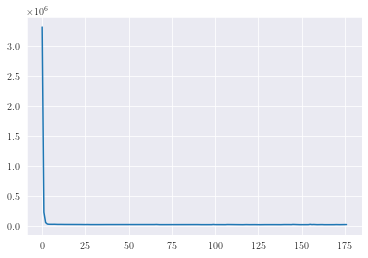

In [13]:
train=df1[:509].values
test=df1[509:].values
mae1, rmse1, smape1 = train_predict(train, test, test)

Epoch 1/400
16/16 [==============================] - 1s 3ms/step - loss: 2615653.2500
Epoch 2/400
16/16 [==============================] - 0s 3ms/step - loss: 224831.0469
Epoch 3/400
16/16 [==============================] - 0s 3ms/step - loss: 83432.9219
Epoch 4/400
16/16 [==============================] - 0s 4ms/step - loss: 54362.3047
Epoch 5/400
16/16 [==============================] - 0s 4ms/step - loss: 48205.2734
Epoch 6/400
16/16 [==============================] - 0s 4ms/step - loss: 47631.9766
Epoch 7/400
16/16 [==============================] - 0s 3ms/step - loss: 47746.4336
Epoch 8/400
16/16 [==============================] - 0s 4ms/step - loss: 47309.3438
Epoch 9/400
16/16 [==============================] - 0s 3ms/step - loss: 46310.2812
Epoch 10/400
16/16 [==============================] - 0s 3ms/step - loss: 47093.0664
Epoch 11/400
16/16 [==============================] - 0s 4ms/step - loss: 46683.0195
Epoch 12/400
16/16 [==============================] - 0s 4ms/step - los

16/16 [==============================] - 0s 6ms/step - loss: 43354.7578
Epoch 98/400
16/16 [==============================] - 0s 8ms/step - loss: 41469.1289
Epoch 99/400
16/16 [==============================] - 0s 8ms/step - loss: 42398.4062
Epoch 100/400
16/16 [==============================] - 0s 7ms/step - loss: 43501.5391
Epoch 101/400
16/16 [==============================] - 0s 6ms/step - loss: 42167.4219
Epoch 102/400
16/16 [==============================] - 0s 7ms/step - loss: 41526.8320
Epoch 103/400
16/16 [==============================] - 0s 7ms/step - loss: 43510.4531
Epoch 104/400
16/16 [==============================] - 0s 8ms/step - loss: 41946.6484
Epoch 105/400
16/16 [==============================] - 0s 8ms/step - loss: 43009.3164
Epoch 106/400
16/16 [==============================] - 0s 7ms/step - loss: 42727.8359
Epoch 107/400
16/16 [==============================] - 0s 7ms/step - loss: 42380.6602
Epoch 108/400
16/16 [==============================] - 0s 6ms/step - l

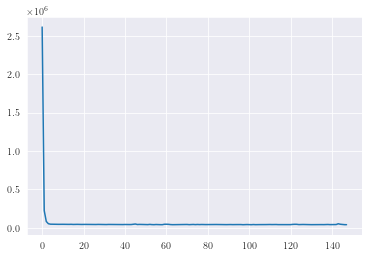

In [14]:
train=df2[:509].values
test=df2[509:].values
mae2, rmse2, smape2 = train_predict(train, test, test)

Epoch 1/400
16/16 [==============================] - 1s 9ms/step - loss: 3893906.5000
Epoch 2/400
16/16 [==============================] - 0s 8ms/step - loss: 339244.6250
Epoch 3/400
16/16 [==============================] - 0s 7ms/step - loss: 129190.2188
Epoch 4/400
16/16 [==============================] - 0s 10ms/step - loss: 96980.4922
Epoch 5/400
16/16 [==============================] - 0s 12ms/step - loss: 91532.7500
Epoch 6/400
16/16 [==============================] - 0s 10ms/step - loss: 91747.1484
Epoch 7/400
16/16 [==============================] - 0s 7ms/step - loss: 90982.9062
Epoch 8/400
16/16 [==============================] - 0s 7ms/step - loss: 90631.2188
Epoch 9/400
16/16 [==============================] - 0s 7ms/step - loss: 89039.1953
Epoch 10/400
16/16 [==============================] - 0s 8ms/step - loss: 88328.0547
Epoch 11/400
16/16 [==============================] - 0s 9ms/step - loss: 89074.8594
Epoch 12/400
16/16 [==============================] - 0s 7ms/step -

16/16 [==============================] - 0s 6ms/step - loss: 77867.3203
Epoch 98/400
16/16 [==============================] - 0s 6ms/step - loss: 74240.4453
Epoch 99/400
16/16 [==============================] - 0s 6ms/step - loss: 79505.4219
Epoch 100/400
16/16 [==============================] - 0s 7ms/step - loss: 73116.6484
Epoch 101/400
16/16 [==============================] - 0s 9ms/step - loss: 74057.2109
Epoch 102/400
16/16 [==============================] - 0s 6ms/step - loss: 72163.0391
Epoch 103/400
16/16 [==============================] - 0s 10ms/step - loss: 73254.1797
Epoch 104/400
16/16 [==============================] - 0s 8ms/step - loss: 76587.2031
Epoch 105/400
16/16 [==============================] - 0s 6ms/step - loss: 72961.7656
Epoch 106/400
16/16 [==============================] - 0s 7ms/step - loss: 72546.8516
Epoch 107/400
16/16 [==============================] - 0s 8ms/step - loss: 74105.7578
Epoch 108/400
16/16 [==============================] - 0s 8ms/step - 

16/16 [==============================] - 0s 6ms/step - loss: 73102.9062
Epoch 193/400
16/16 [==============================] - 0s 5ms/step - loss: 69929.7109
Epoch 194/400
16/16 [==============================] - 0s 4ms/step - loss: 69500.5859
Epoch 195/400
16/16 [==============================] - 0s 5ms/step - loss: 70702.1875
Epoch 196/400
16/16 [==============================] - 0s 5ms/step - loss: 72452.8672
Epoch 197/400
16/16 [==============================] - 0s 8ms/step - loss: 72732.4062
Epoch 198/400
16/16 [==============================] - 0s 5ms/step - loss: 74607.4922
Epoch 199/400
16/16 [==============================] - 0s 5ms/step - loss: 71750.8984
Epoch 200/400
16/16 [==============================] - 0s 5ms/step - loss: 71109.1094
Epoch 201/400
16/16 [==============================] - 0s 5ms/step - loss: 69766.4062
Epoch 202/400
16/16 [==============================] - 0s 8ms/step - loss: 69166.7891
Epoch 203/400
16/16 [==============================] - 0s 8ms/step -

16/16 [==============================] - 0s 6ms/step - loss: 74478.4922
Epoch 288/400
16/16 [==============================] - 0s 10ms/step - loss: 72075.9453
Epoch 289/400
16/16 [==============================] - 0s 8ms/step - loss: 69484.2891
Epoch 290/400
16/16 [==============================] - 0s 8ms/step - loss: 71625.4219
Epoch 291/400
16/16 [==============================] - 0s 7ms/step - loss: 69258.2188
Epoch 292/400
16/16 [==============================] - 0s 6ms/step - loss: 72746.8672
Epoch 293/400
16/16 [==============================] - 0s 7ms/step - loss: 72057.4453
Epoch 294/400
16/16 [==============================] - 0s 7ms/step - loss: 72766.0859
Epoch 295/400
16/16 [==============================] - 0s 9ms/step - loss: 77521.8281
Epoch 296/400
16/16 [==============================] - 0s 7ms/step - loss: 66775.8125
Epoch 297/400
16/16 [==============================] - 0s 8ms/step - loss: 73670.4375
Epoch 298/400
16/16 [==============================] - 0s 7ms/step 

16/16 [==============================] - 0s 6ms/step - loss: 64786.3047
Epoch 383/400
16/16 [==============================] - 0s 7ms/step - loss: 65242.1602
Epoch 384/400
16/16 [==============================] - 0s 7ms/step - loss: 67156.9609
Epoch 385/400
16/16 [==============================] - 0s 9ms/step - loss: 64945.7695
Epoch 386/400
16/16 [==============================] - 0s 8ms/step - loss: 66404.4766
Epoch 387/400
16/16 [==============================] - 0s 8ms/step - loss: 66625.5938
Epoch 388/400
16/16 [==============================] - 0s 7ms/step - loss: 66924.7422
Epoch 389/400
16/16 [==============================] - 0s 6ms/step - loss: 66142.4688
Epoch 390/400
16/16 [==============================] - 0s 6ms/step - loss: 65916.5625
Epoch 391/400
16/16 [==============================] - 0s 8ms/step - loss: 69495.3281
Epoch 392/400
16/16 [==============================] - 0s 9ms/step - loss: 69290.2578
Epoch 393/400
16/16 [==============================] - 0s 8ms/step -

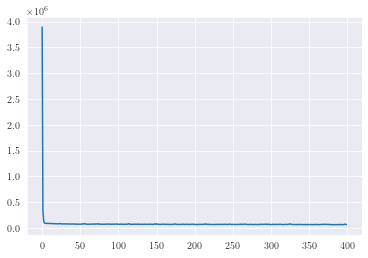

In [15]:
train=df3[:509].values
test=df3[509:].values  
mae3, rmse3, smape3 = train_predict(train, test, test)

### Calculate Error

In [16]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

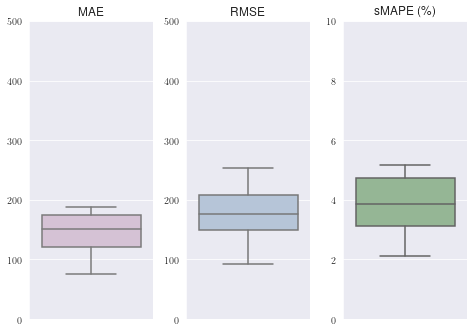

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_MLP_daily_boxplot.pdf')

In [19]:
emer_mlp_day = [mae,rmse,smape]
%store emer_mlp_day

Stored 'emer_mlp_day' (list)
